导入各种包

In [21]:
import tensorflow as tf
from tensorflow import keras

import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

from tinymlgen import port
import math
import numpy as np
import matplotlib.pyplot as plt

构建训练集、验证集、测试集，比例是6：2：2，总数是1000

In [22]:
SAMPLES = 1000

x_values = np.random.uniform(
    low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

np.random.shuffle(x_values)

y_values = np.sin(x_values).astype(np.float32)

y_values += 0.1 * np.random.randn(*y_values.shape)

TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

构建pytorch神经网络的模型结构，结构为最简单的全连接层，和tensoflow lite的hello world例程中网络结构相同

In [23]:
class PytorchSinNet(nn.Module):
    def __init__(self):
        super(PytorchSinNet, self).__init__()
        self.input_layer = nn.Linear(1, 16)
        self.hidden_layer = nn.Linear(16, 16)
        self.output_layer = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        return x

构建和上述pytorch神经网络结构相同的keras模型

In [24]:
def KerasSinNet():
    model = keras.Sequential()
    model.add(keras.layers.Dense(16, activation='relu', input_shape=(1,)))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(1))
    model.compile(optimizer='adam', loss="mse", metrics=["mae"])

    return model

pytorch模型转keras模型的类，支持全连接层、卷积层、BN层，其他类型的层可参考自行实现

In [25]:
class PytorchToKeras(object):
    def __init__(self, pModel, kModel):
        super(PytorchToKeras, self)
        self.__source_layers = []
        self.__target_layers = []
        self.pModel = pModel
        self.kModel = kModel
        tf.keras.backend.set_learning_phase(0)

    def __retrieve_k_layers(self):
        for i, layer in enumerate(self.kModel.layers):
            if len(layer.weights) > 0:
                self.__target_layers.append(i)

    def __retrieve_p_layers(self, input_size):
        input = torch.randn(input_size)
        input = Variable(input.unsqueeze(0))
        hooks = []
        def add_hooks(module):
            def hook(module, input, output):
                if hasattr(module, "weight"):
                    # print(module)
                    self.__source_layers.append(module)
            if not isinstance(module, nn.ModuleList) and not isinstance(module, nn.Sequential) and module != self.pModel:
                hooks.append(module.register_forward_hook(hook))
        self.pModel.apply(add_hooks)
        self.pModel(input)
        for hook in hooks:
            hook.remove()

    def convert(self, input_size):
        self.__retrieve_k_layers()
        self.__retrieve_p_layers(input_size)

        for i, (source_layer, target_layer) in enumerate(zip(self.__source_layers, self.__target_layers)):
            print(source_layer)
            weight_size = len(source_layer.weight.data.size())
            transpose_dims = []
            for i in range(weight_size):
                transpose_dims.append(weight_size - i - 1)
            if isinstance(source_layer, nn.Conv2d):
                transpose_dims = [2,3,1,0]
                self.kModel.layers[target_layer].set_weights([source_layer.weight.data.numpy(
                ).transpose(transpose_dims), source_layer.bias.data.numpy()])
            elif isinstance(source_layer, nn.BatchNorm2d):
                self.kModel.layers[target_layer].set_weights([source_layer.weight.data.numpy(), source_layer.bias.data.numpy(),
                                                              source_layer.running_mean.data.numpy(), source_layer.running_var.data.numpy()])
            elif isinstance(source_layer, nn.Linear):
                self.kModel.layers[target_layer].set_weights([source_layer.weight.data.numpy().T, source_layer.bias.data.numpy().T])

    def save_model(self, output_file):
        self.kModel.save(output_file)

    def save_weights(self, output_file):
        self.kModel.save_weights(output_file, save_format='h5')

用于训练pytorch神经网络时，取一个batch的数据

In [26]:
def get_batch_data(x_dataset, y_dataset, batch_size):
    dataset_length = len(x_dataset)
    index = np.random.randint(0, dataset_length, batch_size)
    x_batch = torch.tensor(x_dataset[index]).resize(batch_size,1)
    y_batch = torch.tensor(y_dataset[index]).resize(batch_size,1)

    return x_batch, y_batch

训练pytorch神经网络

In [27]:
# 超参数
batch_size = 64
epoch_num = 500
learning_rate = 1e-3

train_set_length = len(x_train)
validate_set_length = len(x_validate)
test_set_length = len(x_test)
one_epoch_length = int(train_set_length / batch_size)+1

# 使用GPU
use_cuda = torch.cuda.is_available()
device=torch.device('cuda' if use_cuda else 'cpu')

pytorch_model = PytorchSinNet().to(device)

# 设置loss和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(pytorch_model.parameters(), lr=learning_rate)

print("one epoch length:", one_epoch_length)

# 训练主循环
for epoch in range(epoch_num):
    epoch_loss = 0
    for i in range(one_epoch_length):
        x_batch, y_batch = get_batch_data(x_train, y_train, batch_size)
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        prediction = pytorch_model(x_batch)
        loss = criterion(prediction, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    train_loss = epoch_loss / one_epoch_length
    x_vali = torch.tensor(x_validate).resize(validate_set_length,1).to(device)
    y_vali = torch.tensor(y_validate).resize(validate_set_length,1).to(device)
    prediction = pytorch_model(x_vali)
    validate_loss = criterion(prediction, y_vali)
    print("epoch:{}------train loss:{}------validate loss:{}".format(epoch, train_loss, validate_loss))

# 将模型转到cpu上
pytorch_model = pytorch_model.to(torch.device('cpu'))

one epoch length: 10
epoch:0------train loss:0.8691226243972778------validate loss:0.6217939853668213
epoch:1------train loss:0.5954238772392273------validate loss:0.43671348690986633
epoch:2------train loss:0.4213774800300598------validate loss:0.37963783740997314
epoch:3------train loss:0.3601967692375183------validate loss:0.36287325620651245
epoch:4------train loss:0.33182492852211------validate loss:0.35451048612594604
epoch:5------train loss:0.33565980195999146------validate loss:0.34688544273376465
epoch:6------train loss:0.3241201937198639------validate loss:0.338534951210022
epoch:7------train loss:0.30557307600975037------validate loss:0.3297012746334076


d:\Anaconda3\lib\site-packages\torch\_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


epoch:8------train loss:0.3169418275356293------validate loss:0.3213631808757782
epoch:9------train loss:0.32131415605545044------validate loss:0.31254711747169495
epoch:10------train loss:0.27836865186691284------validate loss:0.304341584444046
epoch:11------train loss:0.29836592078208923------validate loss:0.294969767332077
epoch:12------train loss:0.2765637934207916------validate loss:0.2853837311267853
epoch:13------train loss:0.25399094820022583------validate loss:0.27619317173957825
epoch:14------train loss:0.27464357018470764------validate loss:0.2673548460006714
epoch:15------train loss:0.25899842381477356------validate loss:0.25839582085609436
epoch:16------train loss:0.24174876511096954------validate loss:0.2487240731716156
epoch:17------train loss:0.2436123788356781------validate loss:0.24081043899059296
epoch:18------train loss:0.23722270131111145------validate loss:0.23172029852867126
epoch:19------train loss:0.22101232409477234------validate loss:0.22162814438343048
epoch

创建keras神经网络模型，并将pytorch训练号的神经网络参数复制给keras模型

In [28]:
keras_model = KerasSinNet()

converter = PytorchToKeras(pytorch_model, keras_model)
converter.convert((1))

Linear(in_features=1, out_features=16, bias=True)
Linear(in_features=16, out_features=16, bias=True)
Linear(in_features=16, out_features=1, bias=True)


d:\Anaconda3\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


使用测试集验证pytorch模型和keras模型推理结果的差异

7/7 [==============================] - 0s 2ms/step


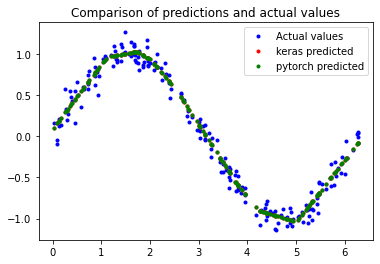

In [29]:
keras_test_pred = keras_model.predict(x_test)

x_te = torch.tensor(x_test).resize(test_set_length, 1)
y_te = torch.tensor(y_test).resize(test_set_length, 1)
pytorch_test_pred = pytorch_model(x_te)
test_loss = criterion(pytorch_test_pred, y_te)

pytorch_test_pred = pytorch_test_pred.detach().numpy()
# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, keras_test_pred, 'r.', label='keras predicted')
plt.plot(x_test, pytorch_test_pred, 'g.', label='pytorch predicted')
plt.legend()
plt.show()

使用tinymlgen这个包可以直接将keras模型转换成ESP32可读的C语言头文件，头文件中包含训练好的神经网络模型参数，这样就可以不使用xxd来生成C语言头文件了

In [30]:
c_code = port(keras_model, optimize=True)
with open('nodemcu32s_sin_led/nn_model.h', 'w') as f:
    f.write(c_code)

INFO:tensorflow:Assets written to: C:\Users\WJ\AppData\Local\Temp\tmpklf8w2o0\assets


INFO:tensorflow:Assets written to: C:\Users\WJ\AppData\Local\Temp\tmpklf8w2o0\assets
